In [1]:
#Importing packages
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,GlobalAveragePooling2D,GlobalMaxPool2D,concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold, StratifiedKFold
import imgaug.augmenters as iaa
from keras_preprocessing.image import ImageDataGenerator
import random as rn
import os
import cv2
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import requests
from tensorflow.keras.applications import VGG16, ResNet50
import datetime
import glob
import warnings
from tensorflow.keras import models, layers
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
import math
from keras.regularizers import l1 ,l2
import keras
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

import argparse
from google.colab import files
import os
import warnings

from keras.callbacks import Callback
from keras import backend as K
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Case_study2/resizedtrain_15.zip -d /content/drive/MyDrive/Colab_Notebooks/Case_study2/traindata_2015/

**Pre-training**


In [21]:
pre_df=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Case_study2/pre_new_2019.csv',dtype=str)

In [22]:
# train test split
from sklearn.model_selection import train_test_split
y = pre_df['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(pre_df, y, test_size=0.20, stratify=y)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4188, 4)
(1047, 4)
(4188,)
(1047,)


**A custom image generator is used to create a multiple output**

In [24]:
# code reference - https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
#tf.keras.backend.clear_session()
def multiple_outputs(generator,dataframe, batch_size, height,width, subset):
    gen = generator.flow_from_dataframe(
        dataframe = dataframe,
        x_col = "path",
        y_col = "diagnosis",
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset)
    
    mlb = MultiLabelBinarizer(classes = range(5))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [25]:
# reference URL - https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.,validation_split = 0.0)

train_generator_2019=multiple_outputs(generator = datagen,dataframe = X_train,
                                   batch_size=32,height = 320, width = 320, subset='training')

**CosineAnnealing scheduler implemetation**

In [220]:
# code reference  - https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)

class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
      super(WarmUpCosineDecayScheduler, self).__init__()
      self.learning_rate_base = learning_rate_base
      self.total_steps = total_steps
      self.global_step = global_step_init
      self.warmup_learning_rate = warmup_learning_rate
      self.warmup_steps = warmup_steps
      self.hold_base_rate_steps = hold_base_rate_steps
      self.verbose = verbose
      self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)
      
    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

In [ ]:
STEP_SIZE_TRAIN = len(X_train) // 32

In [221]:
# Use Cosine LR Scheduler as callback
cosine_lr = WarmUpCosineDecayScheduler(learning_rate_base = 0.0004,
                                       total_steps=STEP_SIZE_TRAIN * 5,
                                       warmup_learning_rate=0.0,
                                       warmup_steps=STEP_SIZE_TRAIN * 5,
                                       hold_base_rate_steps=(2 * STEP_SIZE_TRAIN))

callback_list = [cosine_lr]

**Stage 1 - Pretraining of 2019 APTOS training preprocessed fundus images**

In [222]:
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(320,320,3))

input_layer = Input(shape=(320,320,3),name='Input_Layer')

resnet_layer= resnet_base(input_layer)

gap = GlobalAveragePooling2D()(resnet_layer)
batch1 = BatchNormalization()(gap)

gmp = GlobalMaxPool2D()(resnet_layer)
batch2 = BatchNormalization()(gmp)

#concatinating all inputs
concat_layer = concatenate([batch1,batch2])

#Dense layer of concat data
Dense_concat = Dense(1024, activation='relu')(concat_layer)

# Regression Head
dense1_r = Dense(1024, activation='relu')(Dense_concat)
drop_r = Dropout(0.2)(dense1_r)
dense2_r = Dense(1,activation = 'linear',name = 'regression_head')(drop_r)

# Classification Head
dense1_c = Dense(1024, activation='relu')(Dense_concat)
drop_c = Dropout(0.2)(dense1_c)
dense2_c = Dense(5,activation = 'softmax',name = 'classification_head')(drop_c)

# Ordinal Regression Head
dense1_o = Dense(1024, activation='relu')(Dense_concat)
drop_o = Dropout(0.2)(dense1_o)
dense2_o = Dense(5,activation = 'softmax',name = 'ordinal_head')(drop_o)

model = Model(inputs = [input_layer], outputs = [dense2_r, dense2_c, dense2_o])

94781440/94765736 [==============================] - 0s 0us/step


In [223]:
# to train all the layers
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 10, 10, 2048) 23587712    Input_Layer[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           resnet50[0][0]                   
______________________________________________________________________________________________

In [224]:
# determine Loss function and Optimizer
tf.keras.backend.clear_session()
optimizer = SGD(learning_rate=0.0004)
model.compile(loss={'regression_head': 'mean_absolute_error',
                    'classification_head': 'categorical_crossentropy',
                    'ordinal_head' : 'binary_crossentropy'
                    },
              optimizer=optimizer,
              metrics=['accuracy'])

In [83]:
history = model.fit_generator(train_generator_2019, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, callbacks=callback_list)
model.save('/content/d/premodel_training.h5')

Epoch 1/20
130/130 [==============================] - 105s 776ms/step - loss: 5.0247 - regression_head_loss: 1.8489 - classification_head_loss: 2.1644 - ordinal_head_loss: 1.0114 - regression_head_accuracy: 0.3513 - classification_head_accuracy: 0.2440 - ordinal_head_accuracy: 0.0910
Epoch 2/20
130/130 [==============================] - 102s 785ms/step - loss: 4.1778 - regression_head_loss: 1.4733 - classification_head_loss: 1.8023 - ordinal_head_loss: 0.9023 - regression_head_accuracy: 0.2923 - classification_head_accuracy: 0.3638 - ordinal_head_accuracy: 0.1598
Epoch 3/20
130/130 [==============================] - 101s 775ms/step - loss: 3.6905 - regression_head_loss: 1.3726 - classification_head_loss: 1.5803 - ordinal_head_loss: 0.7376 - regression_head_accuracy: 0.2887 - classification_head_accuracy: 0.4706 - ordinal_head_accuracy: 0.3304
Epoch 4/20
130/130 [==============================] - 101s 779ms/step - loss: 3.3512 - regression_head_loss: 1.3047 - classification_head_loss: 1

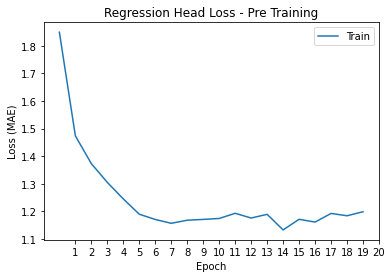

In [84]:
plt.plot(history.history['regression_head_loss'])
plt.title('Regression Head Loss - Pre Training')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

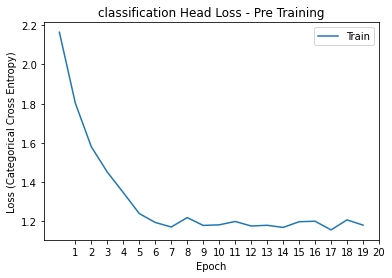

In [85]:
plt.plot(history.history['classification_head_loss'])
plt.title('classification Head Loss - Pre Training')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

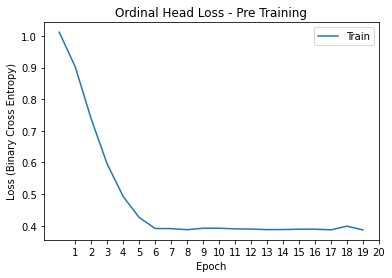

In [86]:
plt.plot(history.history['ordinal_head_loss'])
plt.title('Ordinal Head Loss - Pre Training')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

**Stage 2 - Main Training on 2019 APTOS, MESSIDOR & IDRiD prprocessed fundus images -Part 1(Traing 5 epochs with frozen encoder layers)**

In [225]:
for i in range(-15,0):
  print(model.layers[i])

In [226]:
for layer in model.layers:
    layer.trainable = False

for i in range(-15,0):
  model.layers[i].trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 10, 10, 2048) 23587712    Input_Layer[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           resnet50[0][0]                   
______________________________________________________________________________________________

**Implemetation of Binary_focal & Categorical focal loss**

In [89]:
# code reference - https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def binary_focal_loss(gamma=2., alpha=.25):
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [90]:
# code reference - https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def categorical_focal_loss(gamma=2., alpha=.25):
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

In [91]:
optimizer = Adam(learning_rate=0.004)

model.compile(loss={'classification_head': categorical_focal_loss(alpha=.25, gamma=2), 
                    'regression_head': mean_squared_error,
                    'ordinal_head' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              optimizer=optimizer,
              metrics=['accuracy'])

In [92]:
history1 = model.fit_generator(generator=train_generator_2019, steps_per_epoch=STEP_SIZE_TRAIN, epochs=5, callbacks=callback_list)
model.save('/content/d/model_main_training.h5')

Epoch 1/5
130/130 [==============================] - 102s 765ms/step - loss: 2.4207 - regression_head_loss: 2.1964 - classification_head_loss: 0.0435 - ordinal_head_loss: 0.1808 - regression_head_accuracy: 0.3385 - classification_head_accuracy: 0.5962 - ordinal_head_accuracy: 0.8138
Epoch 2/5
130/130 [==============================] - 99s 764ms/step - loss: 2.4159 - regression_head_loss: 2.1905 - classification_head_loss: 0.0448 - ordinal_head_loss: 0.1807 - regression_head_accuracy: 0.3390 - classification_head_accuracy: 0.5878 - ordinal_head_accuracy: 0.8210
Epoch 3/5
130/130 [==============================] - 99s 760ms/step - loss: 2.3796 - regression_head_loss: 2.1582 - classification_head_loss: 0.0441 - ordinal_head_loss: 0.1773 - regression_head_accuracy: 0.3499 - classification_head_accuracy: 0.5873 - ordinal_head_accuracy: 0.8188
Epoch 4/5
130/130 [==============================] - 99s 760ms/step - loss: 2.3911 - regression_head_loss: 2.1669 - classification_head_loss: 0.0431 -

**Stage 2 - Main Training on 2019 APTOS, MESSIDOR & IDRiD prprocessed fundus images -Part 2(Traing 50 epochs on complete model)**

In [227]:
# Now Unfreeze all Layers and make all layers as trainable = True
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 10, 10, 2048) 23587712    Input_Layer[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           resnet50[0][0]                   
______________________________________________________________________________________________

In [102]:
optimizer = Adam(learning_rate=0.0004)

model.compile(loss={'classification_head': categorical_focal_loss(alpha=.25, gamma=2), 
                    'regression_head': mean_squared_error,
                    'ordinal_head' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              optimizer=optimizer,
              metrics=['accuracy'])

In [103]:
history2 = model.fit_generator(generator=train_generator_2019, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50, callbacks=callback_list)
model.save('/content/d/model_main_training1.h5')

Epoch 1/50
130/130 [==============================] - 106s 777ms/step - loss: 2.4100 - regression_head_loss: 2.1852 - classification_head_loss: 0.0450 - ordinal_head_loss: 0.1799 - regression_head_accuracy: 0.3371 - classification_head_accuracy: 0.5813 - ordinal_head_accuracy: 0.8135
Epoch 2/50
130/130 [==============================] - 101s 778ms/step - loss: 2.3957 - regression_head_loss: 2.1748 - classification_head_loss: 0.0430 - ordinal_head_loss: 0.1779 - regression_head_accuracy: 0.3465 - classification_head_accuracy: 0.5984 - ordinal_head_accuracy: 0.8205
Epoch 3/50
130/130 [==============================] - 101s 778ms/step - loss: 2.3689 - regression_head_loss: 2.1430 - classification_head_loss: 0.0437 - ordinal_head_loss: 0.1822 - regression_head_accuracy: 0.3381 - classification_head_accuracy: 0.5955 - ordinal_head_accuracy: 0.8229
Epoch 4/50
130/130 [==============================] - 100s 772ms/step - loss: 2.4079 - regression_head_loss: 2.1796 - classification_head_loss: 0

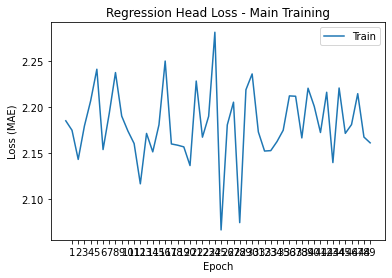

In [110]:
plt.plot(history2.history['regression_head_loss'])
plt.title('Regression Head Loss - Main Training')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,50))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

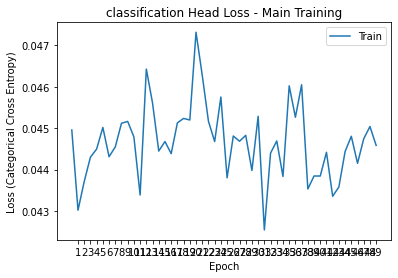

In [111]:
plt.plot(history2.history['classification_head_loss'])
plt.title('classification Head Loss - Main Training')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,50))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

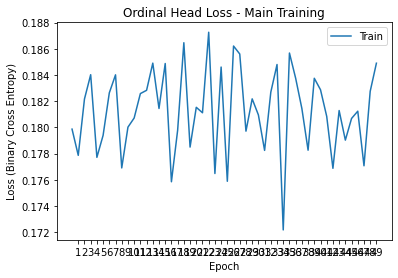

In [112]:
plt.plot(history2.history['ordinal_head_loss'])
plt.title('Ordinal Head Loss - Main Training')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='best')
plt.xticks(range(1,50))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

**Stage 3 - Post Training on 2019 APTOS, MESSIDOR & IDRiD prprocessed fundus images**

In [121]:
# reference URL - https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

datagen=ImageDataGenerator(rescale=1./255., validation_split=0.0, rotation_range=180 , fill_mode='constant', cval=0.0, brightness_range = [0.25 , 1.25], 
                           width_shift_range=0.1, height_shift_range=0.1, channel_shift_range = 0.1, horizontal_flip=True, vertical_flip=True)

train_pred_2019 = datagen.flow_from_dataframe(dataframe=X_train, directory=None, x_col="path", 
                batch_size=1, shuffle=False, class_mode=None, target_size=(320,320))

test_pred_2019=datagen.flow_from_dataframe(dataframe=X_test, directory=None, x_col="path", 
                batch_size=1, shuffle=False, class_mode=None, target_size=(320,320))

Found 4188 validated image filenames.
Found 1047 validated image filenames.


**Prediction of Y labels on train & test fundus images using Main model**

In [122]:
train_y_pred= model.predict_generator(train_pred_2019, steps=len(X_train))

In [124]:
test_y_pred= model.predict_generator(test_pred_2019, steps=len(X_test))

In [125]:
train_class = np.array(np.argmax(train_y_pred[1],axis = -1)).reshape(-1,1)
train_reg = np.array(train_y_pred[0]).reshape(-1,1)
train_ordinal = np.array(np.argmax(train_y_pred[2],axis = -1)).reshape(-1,1)

In [134]:
test_class = np.array(np.argmax(test_y_pred[1],axis = -1)).reshape(-1,1)
test_reg = np.array(test_y_pred[0]).reshape(-1,1)
test_ordinal = np.array(np.argmax(test_y_pred[2],axis = -1)).reshape(-1,1)

**Concatinating the classification, regression & ordinal outputs for training & test data**

In [138]:
X_train_final = np.hstack((train_reg,train_class,train_ordinal))
X_test_final = np.hstack((test_reg,test_class, test_ordinal))

**Building simple linear model to predict the final output**

In [198]:
tf.keras.backend.clear_session()
input_layer_final = Input(shape=(3,))
dense_final = Dense(1,activation = 'linear')(input_layer_final)

final_model = Model(inputs = input_layer_final, outputs = dense_final)

In [199]:
optimizer = SGD(learning_rate=0.0004)
final_model.compile(loss=mean_squared_error, optimizer=optimizer, metrics=['mean_squared_error'])
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [200]:
history3 = final_model.fit(X_train_final,y_train.astype(int), batch_size=32, epochs=50, validation_data = (X_test_final,y_test.astype(int)), verbose=1)
final_model.save("/content/d/final_model.h5")

Epoch 1/50
131/131 [==============================] - 1s 2ms/step - loss: 1.2634 - mean_squared_error: 1.2634 - val_loss: 1.0966 - val_mean_squared_error: 1.0966
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 0.9654 - mean_squared_error: 0.9654 - val_loss: 0.9274 - val_mean_squared_error: 0.9274
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 0.8547 - mean_squared_error: 0.8547 - val_loss: 0.8675 - val_mean_squared_error: 0.8675
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.8457 - val_mean_squared_error: 0.8457
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 0.7968 - mean_squared_error: 0.7968 - val_loss: 0.8376 - val_mean_squared_error: 0.8376
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 0.7902 - mean_squared_error: 0.7902 - val_loss: 0.8347 - val_mean_squared_error: 0.8347
Epoch 7/50
131/131 [========

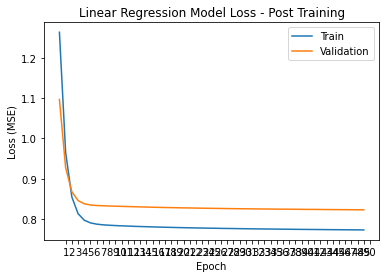

In [201]:
# code reference - https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Linear Regression Model Loss - Post Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,51))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

**Mapping of output to DR grades**

In [202]:
# ref- https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/63%20-%20ResNet50%20-%20Regression%20-%20RGB%20scale.ipynb
'''This Function does nearest integer rounding for regression output from the post training model'''

def classify(x):
    if x < 0.5:
        return 0
    if x < 1.5:
        return 1
    if x < 2.5:
        return 2
    if x < 3.5:
        return 3
    return 4

In [203]:
train_labels = final_model.predict(X_train_final,batch_size=1,verbose = 1)
train_labels1 = np.apply_along_axis(classify, 1, train_labels)

4188/4188 [==============================] - 3s 651us/step


In [204]:
test_labels = final_model.predict(X_test_final,batch_size=1,verbose = 1)
test_labels1 = np.apply_along_axis(classify, 1, test_labels)

1047/1047 [==============================] - 1s 647us/step


**Calculating Cohen kappa & Macro F1 score for training and test images**

In [205]:
print("Quadratic Cohen kappa score of VGG model on train data is: %.3f" % cohen_kappa_score(train_labels1, y_train.astype(int), weights='quadratic'))

Quadratic Cohen kappa score of VGG model on train data is: 0.672


In [206]:
print("Quadratic Cohen kappa score of VGG model on test data is: %.3f" % cohen_kappa_score(test_labels1, y_test.astype(int), weights='quadratic'))

Quadratic Cohen kappa score of VGG model on test data is: 0.642


Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.60      0.71       488
           1       0.18      0.44      0.25       120
           2       0.54      0.59      0.56       292
           3       0.18      0.21      0.20        71
           4       0.25      0.01      0.03        76

    accuracy                           0.51      1047
   macro avg       0.40      0.37      0.35      1047
weighted avg       0.60      0.51      0.53      1047



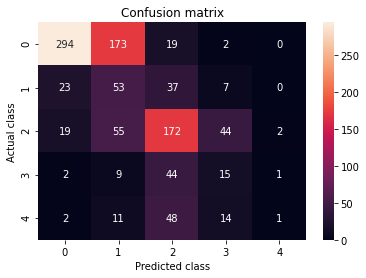

In [207]:
print ('Classification Report : \n', classification_report(y_test.astype('int'), test_labels1))
sns.heatmap(confusion_matrix(y_test.astype('int'), test_labels1), annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()